# **Analysis for one trial**

## This analysis script is for a single trial.

load modules

In [20]:
%load_ext autoreload

%autoreload 2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


set session name

In [21]:
## extract HD cells, for decoding
# name="pk3864-07022022-0109"
# name="pk3864-09022022-0109"

## first trials, for screening
# name="pk3855-21022022-0101"
# name="pk3855-22022022-0101"
# name="pk3855-23022022-0101"
# name="pk3855-24022022-0101"
name="pk3855-25022022-0101"

Check the path

In [22]:
import os

basedir = "/adata/electro"
subject, session = name.split("-",1)
path = basedir+"/"+subject+"/"+name+"/"

fname = name.split("_")[0]

print("Path:", path)
print("Mouse:", subject) # directory = mouse subject name
print("Session:", session)
print("Name:", name, ",", fname)
print("")
print("Path:", "OK" if os.path.isdir(path) else "invalid")

Path: /adata/electro/pk3855/pk3855-25022022-0101/
Mouse: pk3855
Session: 25022022-0101
Name: pk3855-25022022-0101 , pk3855-25022022-0101

Path: OK


## Get a Session object

Check the files

In [23]:
ses = Kilosort_session(name=fname, path=path)
ses.load_parameters_from_files(ignore_params=True)  # ignore_params if kilosort has not been executed so far
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = pk3855-25022022-0101
path = /adata/electro/pk3855/pk3855-25022022-0101
subject = pk3855
session_dat_time = 2022-02-25 01:01:00
fileBase = /adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101
file_names = {'par': '/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.par', 'desen': '/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.desen', 'desel': '/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.desel', 'sampling_rate': '/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.sampling_rate_dat', 'stimulation': '/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.stimulation', 'px_per_cm': '/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.px_per_cm', 'setup': '/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.setup', 'environmentFamiliarity': '/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.environmentFamiliarity', 'params':

## Load spikes

In [24]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
print("stl.clu_ids",stl.clu_ids)
cg = Cell_group(stl)

stl.clu_ids [ 0  1  2  3  4  5  6  7  8  9 11 13 15 19 20 21 22 23 24 25 26 38 39 60
 61 62]


## Load the waveforms

Set the waveform and channel information from the session template file.

In [25]:
cg.set_info_from_session(ses, maxchannels=5)

Templates: 63 , timepoints: 82 , Channels: 64
Loaded templates-clusters-map, spikes: 844191 , clusters: 62
Init shanks: 8


## Create a pose file 

In [26]:
ap = Animal_pose(ses)
posefilename = ses.fileBase + ap.pose_file_extension
print("look for", posefilename)
if not os.path.exists(posefilename):
    print("load from positrack")
    extension = ap.positrack_type()
    print("use extension:",extension)
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50, extension=extension)
    ap.save_pose_to_file() # save the file for next time
else:
    print("load from saved pose file")
    ap.load_pose_from_file()

look for /adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022-0101.pose.npy
load from positrack
use extension: positrack
Interpolation step: 400.0 samples
/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022_01.dat
/adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022_01.positrack
Number of ttl pulses detected: 96403
Number of lines in positrack file: 96403
Saving /adata/electro/pk3855/pk3855-25022022-0101/pk3855-25022022_01.ttl_up.npy
hdRange: 360.92
degree to radian transformation
Invalid values: 33840
Valid values: 448175
Percentage of invalid values: 7.02%
****************************************************************************************
WARNING
The percentage of invalid values is very high. The quality of your data is compromised.
Solve this problem before continuing your experiments.
****************************************************************************************

shape of position data for all trials: (99432, 5)
Saving original pose to /adata/elect

In [27]:
ap.invalid_ratio()

0.07543849062676

In [28]:
ses.trial_intervals.inter

array([[   0.     , 1988.63995]])

In [29]:
ses.trial_intervals.inter[0]

array([   0.     , 1988.63995])

In [30]:
# find good shape automagically & crop
diameter=70.
xyrange_min,xyrange_max=ap.find_xy_range(diameter=diameter)  ###-> do this within intervals , for each trial + use min/max to find best square that covers most of the area
xmean,ymean = ap.meanloc
print("xmean,ymean",xmean,ymean)
print("xyrange_min,xyrange_max",xyrange_min,xyrange_max)

xmean,ymean 43.0244002571869 63.72093161229126
xyrange_min,xyrange_max [12. 27.] [82. 97.]


Plot the path of the animal to see if it was loaded correctly.

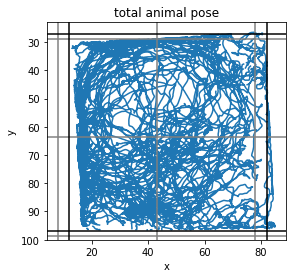

In [31]:
plt.plot(ap.pose[:,1],ap.pose[:,2])
plt.xlabel("x")
plt.ylabel("y")
#plt.scatter([xmean],[ymean], color="black", s=20)
plt.axvline(x=xmean, color="gray")
plt.axhline(y=ymean, color="gray")
plt.axvline(x=xmean+diameter/2, color="gray")
plt.axhline(y=ymean+diameter/2, color="gray")
plt.axvline(x=xmean-diameter/2, color="gray")
plt.axhline(y=ymean-diameter/2, color="gray")

plt.axvline(x=xyrange_min[0], color="black")
plt.axvline(x=xyrange_max[0], color="black")
plt.axhline(y=xyrange_min[1], color="black")
plt.axhline(y=xyrange_max[1], color="black")

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("total animal pose")
plt.show()

Plot the occupancy map to see where the animal spent more or less time.

(The image seems mirrored since the x/y-axis for imshow is different compared to the plot function.)

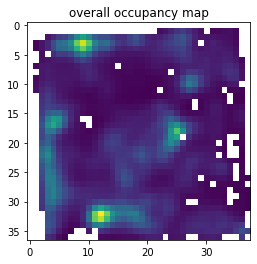

In [32]:
ap.occupancy_map_2d()
plt.imshow(ap.occupancy_map.T)
plt.title("overall occupancy map")
plt.show()

Plot the head-direction of the animal and its position a short segment.

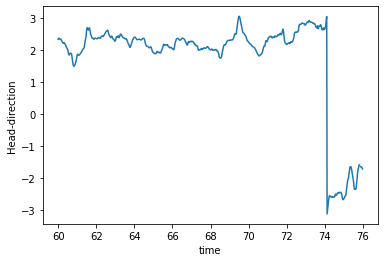

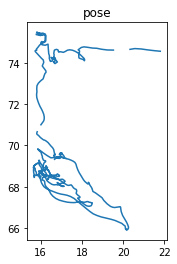

In [33]:
s=3000
e=3800

plt.plot(ap.pose[s:e,0], ap.pose[s:e,4])
plt.xlabel("time")
plt.ylabel("Head-direction")
plt.show()

plt.plot(ap.pose[s:e,1],ap.pose[s:e,2])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("pose")
plt.show()

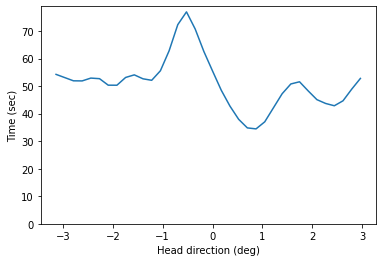

In [34]:
ap.head_direction_occupancy_histogram()
plt.plot(ap.hd_occupancy_bins[:-1],ap.hd_occupancy_histogram)
plt.ylim(0,np.max(ap.hd_occupancy_histogram)+2)
plt.ylabel("Time (sec)")
plt.xlabel("Head direction (deg)")
plt.show()

## Overview

In [35]:
iv=ses.trial_intervals.inter

# iv=np.array([0.,1200.])
# iv=ses.trial_intervals.inter[0]

In [36]:
print("use interval",iv)

use interval [[   0.      1988.63995]]


i 0 / n 0
i 1 / n 1
i 2 / n 2
i 3 / n 3
i 4 / n 4
i 5 / n 5
i 6 / n 6
i 7 / n 7
i 8 / n 8
i 9 / n 9
i 10 / n 11
i 11 / n 13
i 12 / n 15
i 13 / n 19
i 14 / n 20
i 15 / n 21
i 16 / n 22
i 17 / n 23
i 18 / n 24
i 19 / n 25
i 20 / n 26
i 21 / n 38
i 22 / n 39
i 23 / n 60
i 24 / n 61
i 25 / n 62


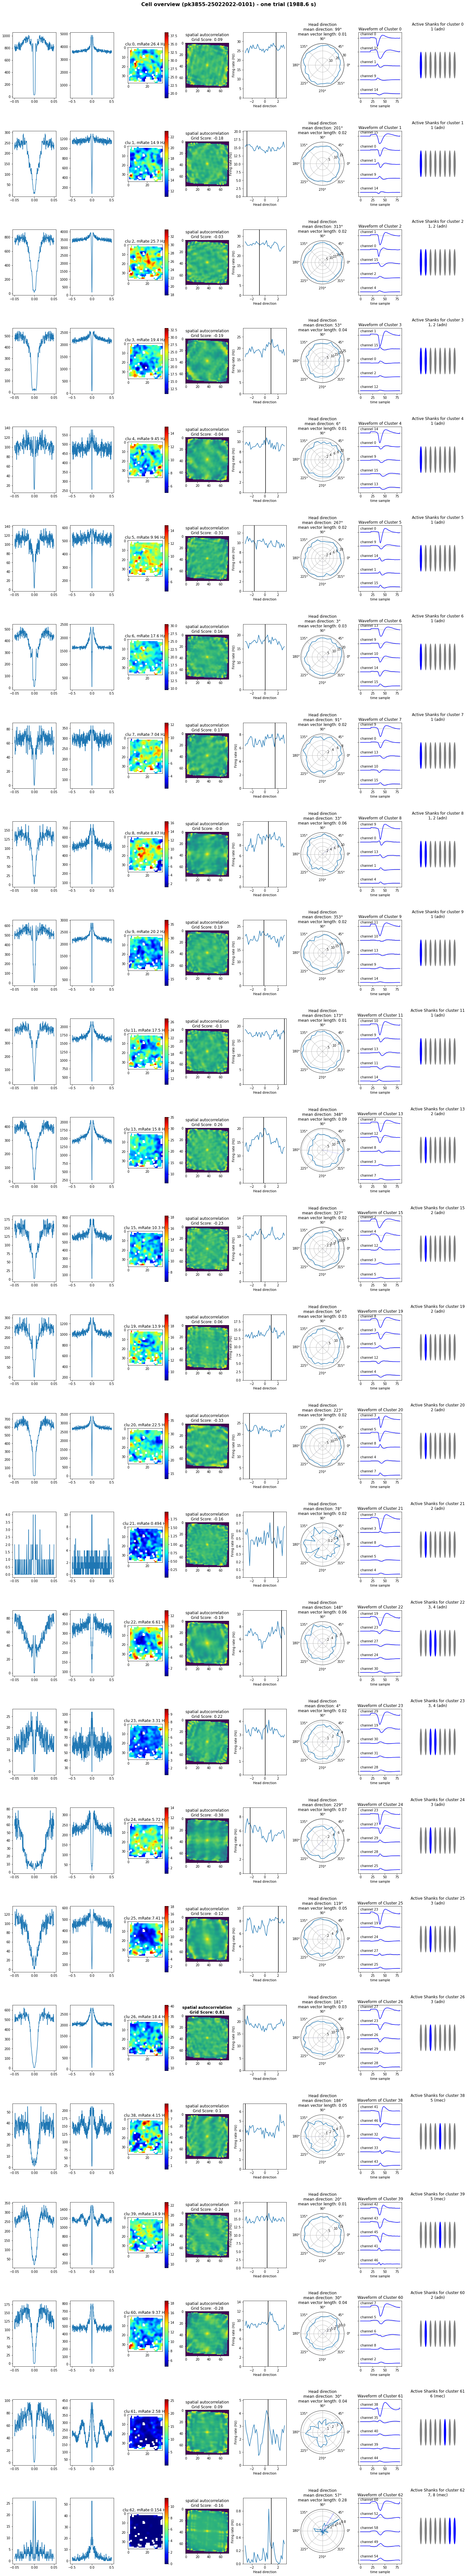

In [40]:
hd_firing_list=[] # neurons tuning curve
hd_ifr_list=[] # ifr list
spike_trains = [] # spike trains


# from matplotlib.patches import Rectangle

cols = 8

fig, axs = plt.subplots(len(cg.neuron_list), cols, figsize=(25, 5*len(cg.neuron_list)))
   
for i, n in enumerate(cg.neuron_list):
    
    # first interval only
    # iv = ses.trial_intervals.inter[0]
    # iv = np.array([iv])
    # custom interval (first 20min of light-dark-protocol -> light baseline)
    # iv=np.array([0.,1200.])
    #iv=np.array([6000.,7200.]) # last 20mins
    #iv=light_intervals
    # iv=np.array(first_block)

    # reset and set intervals
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(iv)
    ap.set_intervals(iv)
    
    n.set_spatial_properties(ap)
    
    print("i",i,"/","n",n.name)
    #print("n",n.spike_train.intervals.total_interval_duration_seconds())
    #print("ap",ap.intervals.total_interval_duration_seconds())
    
    
    
    # temporal auto-correlation
      
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005,min_sec=-0.05, max_sec=0.05)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,0].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0025,min_sec=-0.5, max_sec=0.5)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,1].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    
    # clear intervals
    
    # n.spike_train.unset_intervals()
    # ap.unset_intervals()
    # n.spike_train.set_intervals(ses.trial_intervals.inter)
    # ap.set_intervals(ses.trial_intervals.inter)
    
    # spatial firing map 
    
    n.set_spatial_properties(ap)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)
    im = axs[i,2].imshow(n.spatial_properties.firing_rate_map,cmap='jet')
    axs[i,2].set_title("clu:{}, mRate:{:.3} Hz".format(n.name,n.spike_train.mean_firing_rate()))
    fig.colorbar(im,ax=axs[i,2])
    
    
    # Spatial autocorrelation Map & Grid Score
    gs = n.spatial_properties.grid_score()
    
    fw = "bold" if gs>.4 else "normal"
    
    axs[i,3].imshow(n.spatial_properties.spatial_autocorrelation_map)
    axs[i,3].set_title("spatial autocorrelation"+"\n"+"Grid Score: "+str(round(gs,2)), fontweight=fw)
    
    # Head direction
    
    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
    
    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()
    
    axs[i,4].plot(angles, hd_firing)
    axs[i,4].set_xlabel("Head direction")
    axs[i,4].set_ylabel("Firing rate (Hz)")
    axs[i,4].set_ylim(0,np.max(n.spatial_properties.firing_rate_head_direction_histo)*1.2)
    axs[i,4].axvline(x=hd_mean_direction_rad, color="black")
    #axs[i,4].text(s=str(round(hd_mean_direction_rad*180./np.pi))+" ° (vector length = "+str(hd_mean_vector_length)+")",x=hd_mean+.1,y=1)
    
    fw = "bold" if hd_mean_vector_length>.4 else "normal"
    axs[i,5].axis('off')
    ax2 = fig.add_subplot(len(cg.neuron_list), cols, cols*i+6, polar=True)
    #ax2.plot(angles, hd_firing)
    ax2.plot(np.append(angles,angles[0]), np.append(hd_firing,hd_firing[0]))
    ax2.plot([hd_mean_direction_rad]*2, [0,max(hd_firing)] , color="blue", alpha=hd_mean_vector_length, lw=2.5  )
    ax2.set_title("Head direction" + "\n" + "mean direction: " + str(round( (hd_mean_direction_deg + 360) % 360  )) +"°" + "\n" + "mean vector length: " + str(np.round(hd_mean_vector_length,2))  , fontweight=fw) 
    ax2.grid(True)
    
    
    # Waveforms
    
    cluster = int(n.name) # current cluster name
    channels = ses.get_channels_from_cluster(cluster) # get channels with highest amplitude
    
    if (len(channels)):
    
        for j,channel in enumerate(channels):
            channel_mapped, waveform = ses.get_waveform_from_cluster(cluster, channel)
            axs[i,6].axhline( y = -j*.5 , color="grey" , lw=.5 )
            #label = "channel: "+str(channel)+" ("+str(channel_mapped)+")"
            label = "channel "+str(channel_mapped)
            axs[i,6].plot( waveform -j*.5 , label=label , color="blue")
            axs[i,6].text( s= label , x=0, y=-j*.5 +.1 )
        axs[i,6].set_xlabel("time sample")
        axs[i,6].set(yticklabels=[])  
        axs[i,6].set_title("Waveform of Cluster "+str(cluster))
        
        
    
    # channels / shanks / brain region
    shanks_arr, active_shanks, electrodes = ses.get_active_shanks(channels)
    brain_region = '/'.join(electrodes)
   
    for j, (shank, active) in enumerate(zip(ses.shanks_all, shanks_arr)):
        color = 'blue' if active else 'gray'
        circle = plt.Circle((j,0), 0.2, color=color)
        axs[i,7].add_patch(circle)

    
    axs[i,7].axis('off')
    axs[i,7].set_title("Active Shanks for cluster "+str(cluster)+"\n"+', '.join([str(int(active_shank)) for active_shank in active_shanks]) + " ("+brain_region+")")
    
    axs[i,7].set_xlim([-1, len(ses.shanks_all)])
    axs[i,7].set_ylim([-0.5, 0.5])

    
    
    
    ###########################
    # classify, find category: Grid cell, HD cell
    
    if (hd_mean_vector_length > 0.4):
        n.spike_train.instantaneous_firing_rate(bin_size_sec=2.e-2)
        print("n.name",n.name)
        print("n.spike_train.ifr",n.spike_train.ifr)
        print("n.spike_train.st",n.spike_train.st)
        
        hd_firing_list.append(hd_firing)
        hd_ifr_list.append(n.spike_train.ifr)
        spike_trains.append(n.spike_train.st)
        
        #rect = Rectangle((0.08, 1-(i+.5)/len(cg.neuron_list)), 0.85, 1/len(cg.neuron_list), facecolor='yellow', edgecolor='none', transform=fig.transFigure, zorder=-1)
        #fig.patches.append(rect)

    
    
plt.suptitle("Cell overview ({}) - one trial ({:.1f} s)".format(name, n.spike_train.intervals.total_interval_duration_seconds()), fontsize=16, fontweight='bold')
#plt.tight_layout()
#fig.subplots_adjust(wspace=0.33, hspace=.5)
fig.subplots_adjust(wspace=0.33, hspace=.5, top=0.97)
plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'.pdf')
plt.show()

In [ ]:
# save for HD decoding analysis

In [ ]:
angles = np.array(angles)
print("angles.shape",angles.shape)

hd_firing_list = np.array(hd_firing_list)
print("hd_firing_list.shape",hd_firing_list.shape)

hd_ifr_list = np.array(hd_ifr_list)
print("hd_ifr_list.shape",hd_ifr_list.shape)

spike_trains = np.array(spike_trains)
print("spike_trains.shape",spike_trains.shape)
'''
np.save("angles.npy",angles)
np.save("hd_firing_list.npy",hd_firing_list)
np.save("hd_ifr_list.npy",hd_ifr_list)
np.save("ap-pose.npy",ap.pose)
np.save("spike_trains.npy",spike_trains)
#'''
plt.plot(hd_ifr_list[0,2])
ap.pose[:,0].shape
hd_ifr_list[0,2,:].shape
ap.pose[:,0]
hd_ifr_list[0,2,:]

In [ ]:
# analysis for temporal resolution

In [ ]:
iv

In [ ]:
times = np.linspace(iv[0],iv[1],10)
times

In [ ]:
sub_intervals = ap.times2intervals(times)


In [ ]:
n=cg.neuron_list[-1] #12,22,0,7

In [ ]:
hd_firing_all = []

for sub_interval in sub_intervals:

    # reset and set intervals
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(sub_interval)
    ap.set_intervals(sub_interval)

    n.set_spatial_properties(ap)



    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)

    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()

    plt.plot(angles, hd_firing)
    plt.xlabel("Head direction")
    plt.ylabel("Firing rate (Hz)")
    plt.ylim(0,np.max(n.spatial_properties.firing_rate_head_direction_histo)*1.2)
    plt.axvline(x=hd_mean_direction_rad, color="black")
    plt.show()
    
    hd_firing_all.append(hd_firing)



In [ ]:
# https://stackoverflow.com/a/33505522

from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [ ]:
im = plt.pcolor(angles, range(len(hd_firing_all)), hd_firing_all, shading='auto', cmap='Greys', vmin=0, vmax=np.max(hd_firing_all))
add_colorbar(im)
plt.xlabel("angle")
plt.ylabel("time")
plt.gca().invert_yaxis()
plt.title("HD tuning curve (firing rate), with temporal resolution")
plt.show()

In [ ]:
plt.plot(angles, np.mean(hd_firing_all, axis=0))

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False, figsize=(8,4))
fig.subplots_adjust(hspace=0)

im = axes[0].pcolor(angles, range(len(hd_firing_all)), hd_firing_all, shading='auto', cmap='Greys', vmin=0, vmax=np.max(hd_firing_all))
add_colorbar(im)
axes[0].xlabel("angle")
axes[0].ylabel("time")
axes[0].gca().invert_yaxis()
plt.suptitle("HD tuning curve (firing rate), with temporal resolution")
plt.show()